In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [2]:
from astropy.visualization import astropy_mpl_style
astropy_mpl_style['axes.grid'] = False
plt.style.use(astropy_mpl_style)

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [3]:
# Normalization
def stand_sca(data):
    new_data=(data-data.mean())/data.std()
    return new_data

In [4]:
#读入数据为dataframe格式，并做0均值1标准差处理
df_result = pd.read_excel(r'Benguela-FAO.xlsx')
df_result = df_result.drop(columns=['year', 'region-FAO'])
df_result.head()

,A.landing-sum,S.landing-sum,temp,sea_level
0,1200,1254900,17.532686,-0.042194
1,1000,1283200,17.286786,-0.040990
2,1000,1122600,17.247153,-0.039969
3,1100,1097500,16.829063,-0.039429
4,1100,1613200,16.937153,-0.038531


In [8]:
def hurst(ts, tau):
    
    N = len(ts)
    
    #对数，差分
    new_ts = [np.log10(ts[i]) - np.log10(ts[i-1]) for i in range(1, len(ts))]
    #new_ts = [(ts[i]) - (ts[i-1]) for i in range(1, len(ts))]
    
    #理论最大lag即为将序列等分为两个子集时的子列长度
    max_lag = int(np.floor(N/2))
    #实际最大lag综合vn曲线与rs曲线的突变点来判断
    max_lag = 9
    
    lags = []
    rs_lags = []
    vn_lags = []
    
    #最小time_lag为洋流全序列在pcmci中的tau_max
    for i in range(tau, max_lag+1):
        
        #等分
        subset_list = [ts[p:p+i] for p in range(0,N,i)]
        if np.mod(N,i)>0:
            subset_list.pop()
        
        rs_list = []
        #累积离差
        for clip in subset_list:
            a = []
            c = 0
            #去均值化处理
            clip = stand_sca(np.array(clip))
            m = np.mean(clip)
            for q in range(len(clip)):
                c += clip[q] - m
                a.append(c)
            #子列波动范围R
            R = max(a) - min(a)
            
            #子列标准差S
            S = np.std(clip)
            rs_list.append(R/S)
            
        #重标极差(R/S)n
        rs_lags.append(np.mean(rs_list))
        lags.append(i)
        vn_lags.append(np.mean(rs_list) / np.sqrt(i))
    
    Hurst_exponent = np.polyfit(np.log10(lags),np.log10(rs_lags),1)[0]
    bias = np.polyfit(np.log10(lags),np.log10(rs_lags),1)[1]
    
    return Hurst_exponent, bias, lags, rs_lags, vn_lags

In [9]:
ts = np.array(df_result['A.landing-sum'])
h,b,lags,rs,vn = hurst(ts, 2)
h

0.7684404544157829

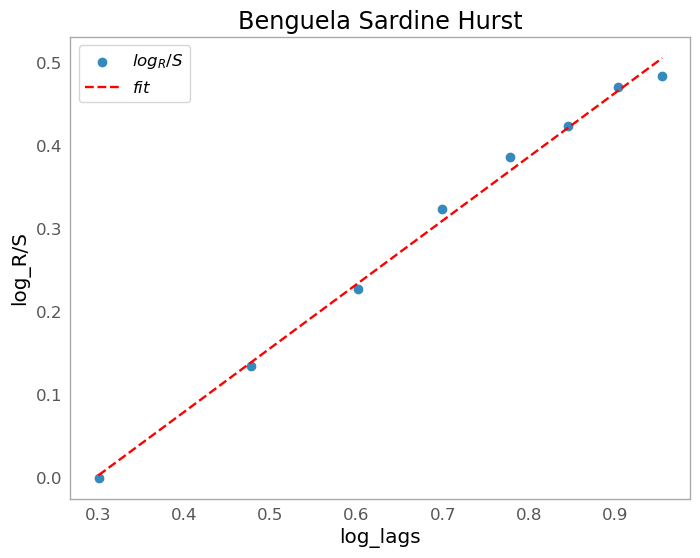

In [10]:
plt.title("Benguela Sardine Hurst")
plt.scatter(np.log10(lags), np.log10(rs), label=r'$log_R/S$')
plt.plot(np.log10(lags), h * np.log10(lags) + b, color = 'r', linestyle='--', label=r'$fit$')
plt.xlabel("log_lags")
plt.ylabel("log_R/S")
plt.legend(loc='best')

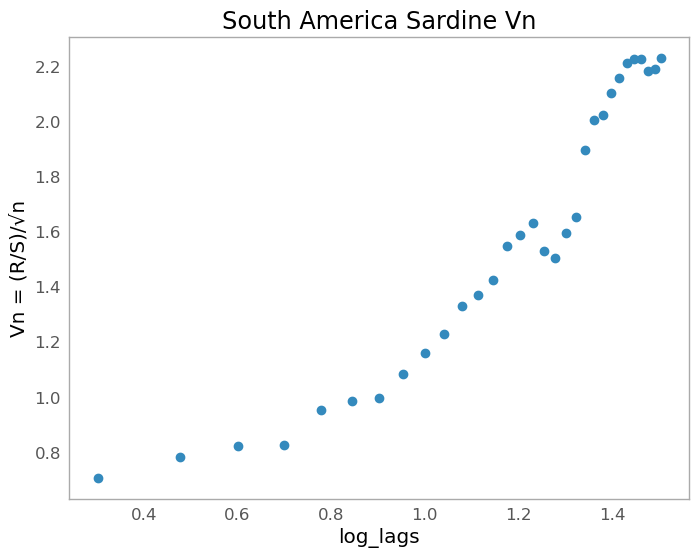

In [14]:
plt.title("South America Sardine Vn")
plt.xlabel("log_lags")
plt.ylabel("Vn = (R/S)/√n")
plt.scatter(np.log10(lags), vn)

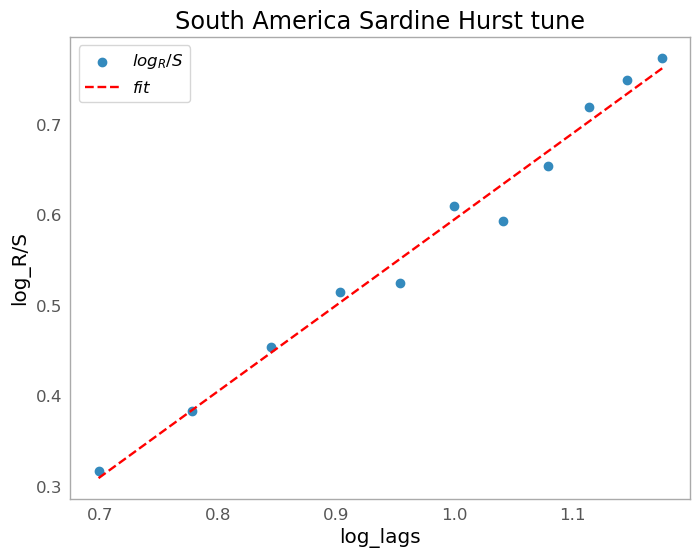

In [198]:
plt.title("South America Sardine Hurst tune")
plt.scatter(np.log10(lags), np.log10(rs), label=r'$log_R/S$')
plt.plot(np.log10(lags), h * np.log10(lags) + b, color = 'r', linestyle='--', label=r'$fit$')
plt.xlabel("log_lags")
plt.ylabel("log_R/S")
plt.legend(loc='best')

In [15]:
a = [1,2,3,4,5,6,7]
a = stand_sca(np.array(a))
a

array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5])

In [17]:
max(a) - min(a)

3.0